In [23]:
# !pip install xgboost optuna sklearn

In [51]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import joblib
import seaborn as sns

import xgboost as xgb
import optuna
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, auc, f1_score, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Reading a Dataset to Train a Model

In [53]:
data = pd.read_excel('final_dataset.xlsx')
data

,full_name,age,height,citizenship,player_agent,current_club,joined,outfitter,social_media,link,...,club_trophies_total_score,club_trophies_average_score,club_trophies_max_score,club_trophies_min_score,club_trophies_amount,Defender_Group,Midfielder_Group,Striker_Group,Winger_Group,followers
0,Joško Gvardiol,22.0,1.85,Croatia,1,Manchester City,7,0,"('Instagram', 'http://www.instagram.com/josko_...",https://www.transfermarkt.com/josko-gvardiol/p...,...,303,37.875,81,8,9,2,0,0,0,1199636
1,Nathan Benjamin Aké,29.0,1.80,Netherlands Cote d'Ivoire,1,Manchester City,43,1,http://www.instagram.com/nathanake/,https://www.transfermarkt.com/nathan-ake/profi...,...,303,37.875,81,8,9,2,0,0,0,2227475
2,Sergio Gómez Martín,23.0,1.71,Spain,1,Manchester City,18,0,http://www.instagram.com/sergiogm_10/,https://www.transfermarkt.com/sergio-gomez/pro...,...,303,37.875,81,8,9,1,0,0,1,475430
3,Kyle Andrew Walker,33.0,1.78,England,1,Manchester City,79,1,http://www.instagram.com/kylewalker2/,https://www.transfermarkt.com/kyle-walker/prof...,...,303,37.875,81,8,9,1,0,0,1,4911531
4,Matheus Luiz Nunes,25.0,1.83,Portugal Brazil,1,Manchester City,6,0,"('Instagram', 'http://www.instagram.com/matheu...",https://www.transfermarkt.com/matheus-nunes/pr...,...,303,37.875,81,8,9,0,2,0,0,447746
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16135,João Vítor de Oliveira Florêncio,26.0,1.82,Brazil,0,Nadur Youngsters FC,8,0,NaN,https://www.transfermarkt.com/robinho/profil/s...,...,0,0.000,0,2,0,0,0,1,1,0
16136,Rafael Conrado Prudente,29.0,1.89,Brazil,0,Oratory Youths FC,1,0,NaN,https://www.transfermarkt.com/rafael-conrado/p...,...,0,0.000,0,2,0,0,0,2,0,0
16137,Johandre Jose Padilla Vasquez,26.0,1.82,Colombia,0,Ghajnsielem FC,2,0,NaN,https://www.transfermarkt.com/johandre-padilla...,...,0,0.000,0,2,0,2,0,0,0,0
16138,Cláudio Henrique da Silva Barboza,25.0,1.64,Brazil,0,Ghajnsielem FC,7,0,NaN,https://www.transfermarkt.com/claudio-murici/p...,...,0,0.000,0,2,0,0,0,1,1,0


In [74]:
print(f"Number of rows in the dataset: {data.shape[0]}")
print(f"Number of columns in the dataset: {data.shape[1]}")

Number of rows in the dataset: 16140
Number of columns in the dataset: 64


In [8]:
data = data.fillna(0)

print("Fill missing values with zero")
print("Missing values:", data.isna().sum().sum())

Fill missing values with zero
Missing values: 0


## Predicting Anomaly Value Model

In [9]:
relevant_features = [
    'age',
     'height',
     'player_agent',
     'joined',
     'outfitter',
     'appearances',
     'goals',
     'assists',
     'substitutions_on',
     'substitutions_off',
     'yellow_cards',
     'red_cards',
     'penalty_goals',
     'minutes_played',
     'individual',
     'international',
     'national',
     'other',
     'national_status',
     'national_matches',
     'national_goals',
     'national_assists',
     'national_yellow_cards',
     'national_red_cards',
     'avg_injuries_per_season',
     'avg_injury_duration',
     'is_injured',
     'last_injury_date',
     'club_price',
     'club_statistics_matches',
     'club_statistics_goals',
     'club_statistics_pts',
     'club_league_top_rank',
     'club_league_lowest_rank',
     'club_league_mean_rank',
     'foot_left',
     'foot_right',
     'trophies_total_score',
     'trophies_average_score',
     'trophies_max_score',
     'trophies_min_score',
     'trophies_amount',
     'club_trophies_total_score',
     'club_trophies_average_score',
     'club_trophies_max_score',
     'club_trophies_min_score',
     'club_trophies_amount',
     'Defender_Group',
     'Midfielder_Group',
     'Striker_Group',
     'Winger_Group',
     'followers'
]

In [10]:
# Loading a predictive model
rf_model = joblib.load('rf_model.joblib')

In [11]:
# Predicting values
predicted_prices = rf_model.predict(data[relevant_features])
data['predicted_price'] = predicted_prices 

In [12]:
# Calculation of the difference between the predicted and current price
data['price_difference'] = np.abs(predicted_prices - data['current_price'])

In [13]:
# Calculation of standard deviation of price difference in millions
sigma = np.std(data['price_difference']) / 1e6

# Definition of threshold for anomaly: more than 3 sigma million
threshold = 3 * sigma
print(f"The threshold for anomaly is {threshold} millions €.")

# Anomaly detection based on threshold
data['is_anomalous'] = (data['price_difference'] / 1e6 > threshold).astype(int)

The threshold for anomaly is 3.677777908007968 millions €.


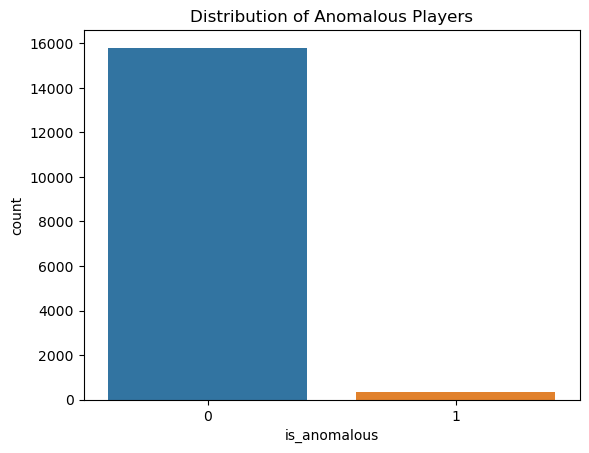

In [40]:
sns.countplot(x='is_anomalous', data=data)
plt.title('Distribution of Anomalous Players')
plt.show()

In [14]:
anomaly = data[data['is_anomalous'] == 1]

anomaly[['full_name',
      'age',
      'height',
      'citizenship',
      'current_club', 
      'current_price',
      'predicted_price',
      'price_difference', 
      'is_anomalous']]

,full_name,age,height,citizenship,current_club,current_price,predicted_price,price_difference,is_anomalous
0,Joško Gvardiol,22.0,1.85,Croatia,Manchester City,80000000,7.004785e+07,9.952153e+06,1
1,Nathan Benjamin Aké,29.0,1.80,Netherlands Cote d'Ivoire,Manchester City,40000000,4.555263e+07,5.552632e+06,1
3,Kyle Andrew Walker,33.0,1.78,England,Manchester City,13000000,1.697847e+07,3.978469e+06,1
4,Matheus Luiz Nunes,25.0,1.83,Portugal Brazil,Manchester City,55000000,4.960048e+07,5.399522e+06,1
5,Bernardo Mota Veiga de Carvalho e Silva,29.0,1.73,Portugal,Manchester City,80000000,7.570335e+07,4.296651e+06,1
...,...,...,...,...,...,...,...,...,...
5056,Cameron Robert Carter-Vickers,26.0,1.83,United States England,Celtic FC,13000000,8.881741e+06,4.118259e+06,1
5147,0,25.0,1.73,England India,Ross County FC,800000,5.694202e+06,4.894202e+06,1
5653,Матвієнко Микола Олександрович,27.0,1.82,Ukraine,Shakhtar Donetsk,20000000,1.448094e+07,5.519065e+06,1
5675,Судаков Георгій Вікторович,21.0,1.77,Ukraine,Shakhtar Donetsk,18000000,1.349844e+07,4.501558e+06,1


In [67]:
# First, let's ensure that 'citizenship', 'current_club', and 'club_league' columns are treated as categorical
anomaly['citizenship'] = anomaly['citizenship'].astype('category')
anomaly['current_club'] = anomaly['current_club'].astype('category')
anomaly['club_league'] = anomaly['club_league'].astype('category')

/var/folders/3d/lk68rk7n1193l_m6m4f2nlkw0000gp/T/ipykernel_44735/1289287725.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomaly['citizenship'] = anomaly['citizenship'].astype('category')
/var/folders/3d/lk68rk7n1193l_m6m4f2nlkw0000gp/T/ipykernel_44735/1289287725.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomaly['current_club'] = anomaly['current_club'].astype('category')
/var/folders/3d/lk68rk7n1193l_m6m4f2nlkw0000gp/T/ipykernel_44735/1289287725.py:4: SettingWithCopyWarning: 
A value is tr

In [68]:
# Now, let's find the 3 most frequent values in each of these columns
citizenship_top5 = anomaly['citizenship'].value_counts().head(5)
current_club_top5 = anomaly['current_club'].value_counts().head(5)
club_league_top5 = anomaly['club_league'].value_counts().head(5)

In [69]:
citizenship_top5

citizenship
Spain       24
England     17
Portugal    17
Germany     15
Brazil      11
Name: count, dtype: int64

In [70]:
club_league_top5

club_league
Premier League    121
Bundesliga         50
LaLiga             47
Serie A            44
Ligue 1            26
Name: count, dtype: int64

In [71]:
current_club_top5

current_club
Manchester City     15
Real Madrid         14
Chelsea FC          13
Bayern Munich       12
Newcastle United    12
Name: count, dtype: int64

In [72]:
numeric_data = anomaly.select_dtypes(include=['number'])
numeric_cols = numeric_data.columns.values

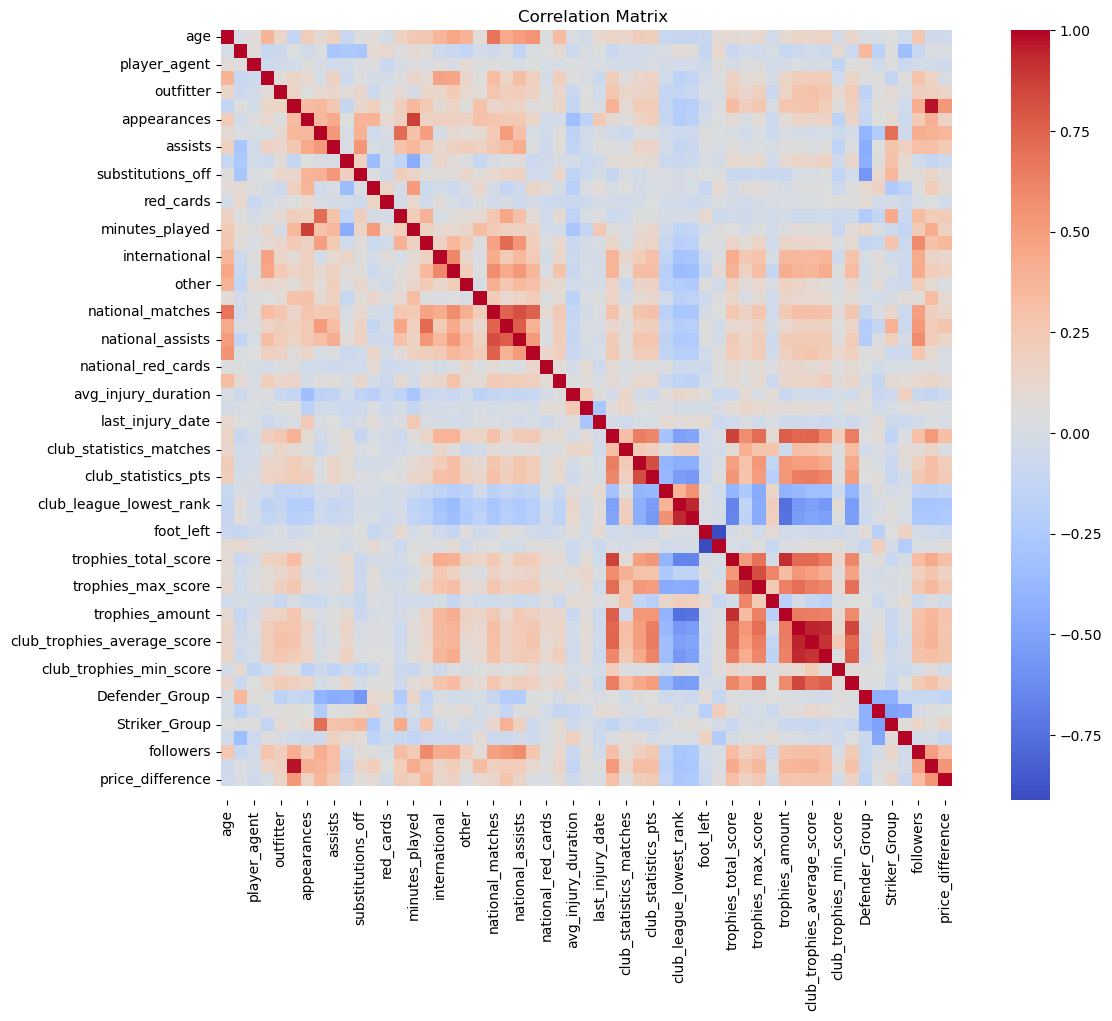

In [73]:
# Visualizing the correlation matrix to understand relationships between features
plt.figure(figsize=(12, 10))
correlation_matrix = numeric_data.corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

--------

# Predicting Anomaly Value Model

In [20]:
ddata = data[relevant_features]
ddata['is_anomalous'] = data['is_anomalous']
ddata.columns.values

/var/folders/3d/lk68rk7n1193l_m6m4f2nlkw0000gp/T/ipykernel_58906/145649380.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ddata['is_anomalous'] = data['is_anomalous']


array(['age', 'height', 'player_agent', 'joined', 'outfitter',
       'appearances', 'goals', 'assists', 'substitutions_on',
       'substitutions_off', 'yellow_cards', 'red_cards', 'penalty_goals',
       'minutes_played', 'individual', 'international', 'national',
       'other', 'national_status', 'national_matches', 'national_goals',
       'national_assists', 'national_yellow_cards', 'national_red_cards',
       'avg_injuries_per_season', 'avg_injury_duration', 'is_injured',
       'last_injury_date', 'club_price', 'club_statistics_matches',
       'club_statistics_goals', 'club_statistics_pts',
       'club_league_top_rank', 'club_league_lowest_rank',
       'club_league_mean_rank', 'foot_left', 'foot_right',
       'trophies_total_score', 'trophies_average_score',
       'trophies_max_score', 'trophies_min_score', 'trophies_amount',
       'club_trophies_total_score', 'club_trophies_average_score',
       'club_trophies_max_score', 'club_trophies_min_score',
       'club_trophie

In [22]:
X = ddata[relevant_features]
y = ddata['is_anomalous']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### optuna part

In [27]:
def objective(trial):
    param = {
        'verbosity': 0,
        'objective': 'binary:logistic',
        'booster': trial.suggest_categorical('booster', ['gbtree', 'dart']),  # Only choose between gbtree and dart
        'lambda': trial.suggest_float('lambda', 1e-3, 1.0, log=True),  # Range
        'alpha': trial.suggest_float('alpha', 1e-3, 1.0, log=True),  # Range
        'max_depth': trial.suggest_int('max_depth', 3, 7),  # Depth range narrowed
        'eta': trial.suggest_float('eta', 0.01, 0.2, log=True),  # Learning rate range narrowed
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),  # RangeRange
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),  # Range
        'early_stopping_rounds': 50
    }

    clf = xgb.XGBClassifier(**param)
    clf.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False, eval_metric="logloss")

    preds = clf.predict(X_test)
    f1 = f1_score(y_test, preds)
    return f1

In [28]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2024-05-24 18:12:21,326] A new study created in memory with name: no-name-ec88657c-2dc1-45fc-960d-a0a14fa7e02b
/opt/anaconda3/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-05-24 18:12:36,573] Trial 0 finished with value: 0.2247191011235955 and parameters: {'booster': 'dart', 'lambda': 0.0012588369755989041, 'alpha': 0.08528887561793586, 'max_depth': 7, 'eta': 0.017464776321615878, 'subsample': 0.5007856984606737, 'colsample_bytree': 0.516439498051522}. Best is trial 0 with value: 0.2247191011235955.
/opt/anaconda3/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-05-24 18:12:52,270] Trial 1 finished with value: 0.

In [41]:
# Best params
print("Best trial:")
trial = study.best_trial

print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

Best trial:
  Value: 0.45045045045045046
  Params: 
    booster: dart
    lambda: 0.017883665686658928
    alpha: 0.019450565236428755
    max_depth: 4
    eta: 0.18416621851547876
    subsample: 0.8432749874407426
    colsample_bytree: 0.8067053527182989


### main body

In [42]:
# Обучение модели с лучшими параметрами
model = xgb.XGBClassifier(**trial.params)
model.fit(X_train, y_train)

XGBClassifier(alpha=0.019450565236428755, base_score=None, booster='dart',
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8067053527182989, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eta=0.18416621851547876, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=0.017883665686658928,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None, ...)

In [45]:
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

Accuracy: 0.9798636926889716
F1 Score: 0.40366972477064217


In [34]:
# Output the significance of features
print("Feature Importances:")
print(model.feature_importances_)

Feature Importances:
[0.02693598 0.01382724 0.00623224 0.02354696 0.01716243 0.02313536
 0.03171564 0.01724354 0.01366951 0.01249642 0.01195192 0.01313211
 0.01174634 0.01774784 0.01248567 0.01544866 0.01171102 0.00945997
 0.02994882 0.01562925 0.01876713 0.02139047 0.01212086 0.01630938
 0.01634893 0.01508403 0.02444968 0.01162684 0.17780241 0.01468574
 0.01590035 0.01544608 0.01412731 0.02446179 0.01199596 0.00241248
 0.00895216 0.01111143 0.01502975 0.03620031 0.01630047 0.01789658
 0.0363833  0.01172484 0.01258993 0.01370138 0.0104293  0.
 0.01183588 0.00924219 0.0142869  0.02615911]


### Trying to Raise F1-score

SMOTE should help balance the data and improve the F1-score for the minority class.

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score

In [47]:
# Applying SMOTE to training data
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [48]:
# Model training
model = RandomForestClassifier(random_state=42)
model.fit(X_train_res, y_train_res)

RandomForestClassifier(random_state=42)

In [49]:
# Prediction on training data
y_pred = model.predict(X_test)

In [50]:
# Evaluation
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1}')

Accuracy: 0.9798636926889716
F1 Score: 0.5185185185185185
